In [2]:
import os

import time
import urllib
import cv2
import numpy as np
import torch

from detect_and_track import SAMTracker, YOLODetector
from visualizer import Visualizer

In [3]:
# Define the file path and URL
VIDEO_STREAM = "./TUD-Stadtmitte-raw.webm"
url = 'https://motchallenge.net/sequenceVideos/TUD-Stadtmitte-raw.webm'

# Check if the file already exists
if not os.path.exists(VIDEO_STREAM):
    # If the file doesn't exist, download it
    urllib.request.urlretrieve(url, VIDEO_STREAM)
    print(f"Downloading {VIDEO_STREAM}...")
else:
    print(f"File {VIDEO_STREAM} already exists, skipping download.")

In [6]:
NUM_OBJECTS = 3
YOLO_CHECKPOINT_FILEPATH = "yolov8x-seg.pt"
SAM_CHECKPOINT_FILEPATH = "../checkpoints/sam2.1_hiera_base_plus.pt"
SAM_CONFIG_FILEPATH = "./configs/samurai/sam2.1_hiera_b+.yaml"
OUTPUT_PATH = VIDEO_STREAM + "_segmented.mp4"
DEVICE = 'cuda:0'

In [7]:
# Instantiate Object Detector
detector = YOLODetector(ckpt_path=YOLO_CHECKPOINT_FILEPATH, 
                        conf_threshold=0.6, 
                        device=DEVICE, 
                        labels=[0]
                        )

# Instantiate Object Tracker
tracker = SAMTracker(config_file=SAM_CONFIG_FILEPATH,
                     ckpt_path=SAM_CHECKPOINT_FILEPATH,
                     num_objects=NUM_OBJECTS,
                     device=DEVICE,
                     iou_threshold=0.7
                     )

In [8]:
# Open video stream
video_stream = cv2.VideoCapture(VIDEO_STREAM)

video_height = int(video_stream.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video_stream.get(cv2.CAP_PROP_FRAME_WIDTH))

# For real-time visualization
visualizer = Visualizer(video_width=256,
                        video_height=256,
                        num_masks=NUM_OBJECTS,
                        save_video=True,
                        output_notebook=True,
                        output_path=OUTPUT_PATH
                        )

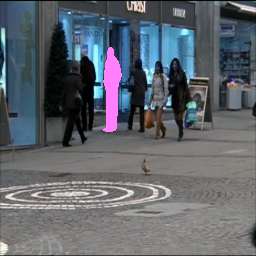

In [9]:
available_slots = np.inf

with torch.inference_mode(), torch.autocast('cuda:0', dtype=torch.bfloat16):
    while video_stream.isOpened():
        start_time = time.time()

        # Get next frame
        ret, frame = video_stream.read()
        
        # Exit if no frames remaining
        if not ret:
            break

        # Convert frame from BGR to RGB
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Get detections from YOLO
        detections = detector.get_detections(img=img) if available_slots > 0 else None
        
        sam_out = tracker.track_frame(img=img)
    
        if detections is not None:
            new_object_masks = tracker.check_for_new_objects(object_masks=detections['masks'],
                                                             sam_masks=sam_out['pred_masks']
                                                             )
    
            available_slots = tracker.num_objects - tracker.sam.curr_obj_idx
    
            if len(new_object_masks) > 0 and available_slots > 0:
                sam_out = tracker.track_new_object(new_object_masks=new_object_masks,
                                                   tracked_object_masks=sam_out['pred_masks']
                                                   )
    
        tracker.update_memory_bank(prediction=sam_out)
        
        visualizer.add_frame(frame=frame, mask=sam_out['pred_masks'])

visualizer.stop()
video_stream.release()